In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [87]:
# Загрузка данных
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Проверка на пропущенные значения
print(train_df.isnull().sum())

area             0
perimeter        0
major_axis       0
minor_axis       0
eccentricity     0
eqdiasq          0
solidity         0
convex_area      0
extent           0
aspect_ratio     0
roundness        0
compactness      0
shapefactor_1    0
shapefactor_2    0
shapefactor_3    0
shapefactor_4    0
target           0
dtype: int64


In [88]:
train_df.shape

(1288, 17)

In [89]:
def detect_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        print(f"Outliers in {feature}: {len(outliers)}")
        # Удаление выбросов
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

features = train_df.columns[:-1]  # Все признаки кроме target
train_df = detect_outliers(train_df, features)
train_df.shape

Outliers in area: 16
Outliers in perimeter: 53
Outliers in major_axis: 13
Outliers in minor_axis: 9
Outliers in eccentricity: 25
Outliers in eqdiasq: 2
Outliers in solidity: 36
Outliers in convex_area: 0
Outliers in extent: 33
Outliers in aspect_ratio: 3
Outliers in roundness: 0
Outliers in compactness: 0
Outliers in shapefactor_1: 2
Outliers in shapefactor_2: 13
Outliers in shapefactor_3: 0
Outliers in shapefactor_4: 51


(1032, 17)

In [90]:
# Генерация новых признаков
def generate_features(df):
    df['shape_interaction'] = df['shapefactor_1'] * df['shapefactor_3'] / (df['shapefactor_2'])
    df['area2'] = (df['area'] + df['perimeter']) / (df['major_axis'] * df['minor_axis'])

    return df

train_df = generate_features(train_df)
test_df = generate_features(test_df)


target               1.000000
shapefactor_1        0.718632
aspect_ratio         0.640905
eccentricity         0.639064
shapefactor_2        0.180050
perimeter           -0.102783
major_axis          -0.113618
extent              -0.114312
roundness           -0.188731
shape_interaction   -0.200992
area2               -0.219064
shapefactor_4       -0.251396
solidity            -0.256360
convex_area         -0.596171
eqdiasq             -0.622677
area                -0.626710
compactness         -0.679587
shapefactor_3       -0.679597
minor_axis          -0.712240
Name: target, dtype: float64


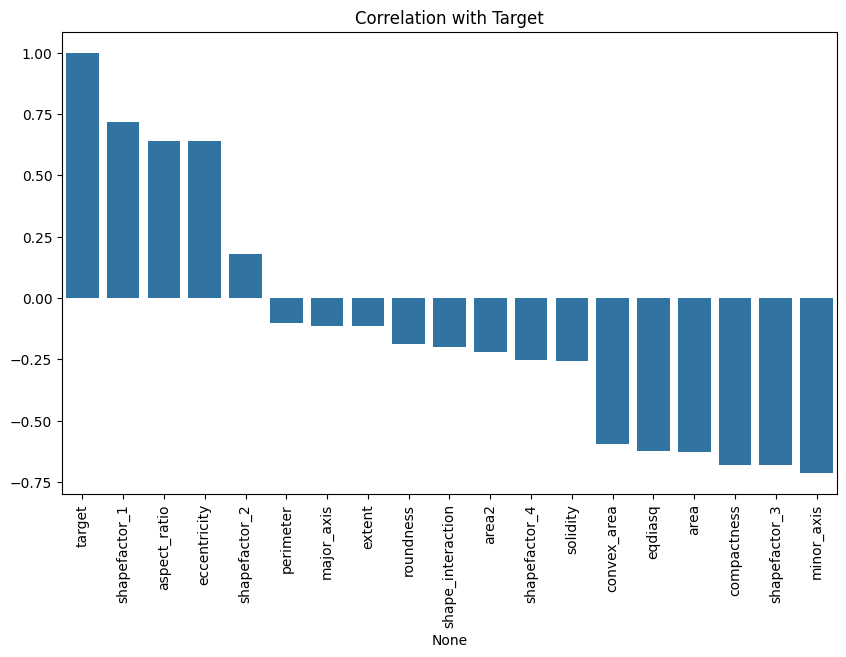

In [91]:
# Корреляция признаков с таргетом
correlation_matrix = train_df.corr()
target_corr = correlation_matrix['target'].sort_values(ascending=False)
print(target_corr)

plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values)
plt.xticks(rotation=90)
plt.title("Correlation with Target")
plt.show()

In [92]:
# Логарифмирование
for col in ['area', 'perimeter', 'major_axis', 'minor_axis', 'convex_area']:
    train_df[col] = np.log1p(train_df[col])
    test_df[col] = np.log1p(test_df[col])

# plt.figure(figsize=(30, 30))
# for i, col in enumerate(list(train_df.columns)):
#     plt.subplot(7, 4, i+1)
#     sns.histplot(train_df[col], kde=True, bins=10)

In [93]:
from sklearn.preprocessing import PowerTransformer

# Обработка асимметрии
skew_columns = train_df.skew().sort_values(ascending=False)
high_skew = skew_columns[abs(skew_columns) > 0.8].index.tolist()
pt = PowerTransformer(method='yeo-johnson')
train_df[high_skew] = pt.fit_transform(train_df[high_skew])
test_df[high_skew] = pt.fit_transform(test_df[high_skew])

In [94]:
# Разделение данных
X = train_df.drop(columns=['target'])
y = train_df['target']

X_test = test_df

In [95]:
scaler = StandardScaler()

X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=train_df.drop(columns=['target']).columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=test_df.columns)

In [96]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [97]:
# Проверка распределения классов
print(pd.Series(y_train).value_counts())

target
1    476
0    349
Name: count, dtype: int64


In [98]:
# Применение SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Проверка баланса после upsampling
print(pd.Series(y_train).value_counts())

target
0    476
1    476
Name: count, dtype: int64


In [99]:
# Удаление ненужных столбцов
columns_to_drop = ['eqdiasq', 'shapefactor_3', 'shapefactor_4', 'area']

X_train = X_train.drop(columns=columns_to_drop)
X_val = X_val.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

In [100]:
# Исходная accuracy
baseline_model = SVC(random_state=42, verbose=0)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_val)
baseline_accuracy = accuracy_score(y_val, y_pred)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

# Проверка удаления признаков
features_to_test = X_train.columns.tolist()
best_accuracy = baseline_accuracy
best_features = features_to_test.copy()

for feature in features_to_test:
    # Удаление одного признака
    reduced_X_train = X_train.drop(columns=[feature])
    reduced_X_val = X_val.drop(columns=[feature])

    # Обучение модели
    model = SVC(random_state=42, verbose=0)
    model.fit(reduced_X_train, y_train)
    y_pred = model.predict(reduced_X_val)
    current_accuracy = accuracy_score(y_val, y_pred)

    print(f"Removing {feature}: Accuracy = {current_accuracy:.4f}")

    # Обновление лучшего результата
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_features = reduced_X_train.columns.tolist()

print(f"Best Accuracy: {best_accuracy:.4f}")
print("Best features:", best_features)

Baseline Accuracy: 0.9324
Removing perimeter: Accuracy = 0.9324
Removing major_axis: Accuracy = 0.9372
Removing minor_axis: Accuracy = 0.9420
Removing eccentricity: Accuracy = 0.9420
Removing solidity: Accuracy = 0.9372
Removing convex_area: Accuracy = 0.9420
Removing extent: Accuracy = 0.9227
Removing aspect_ratio: Accuracy = 0.9420
Removing roundness: Accuracy = 0.9324
Removing compactness: Accuracy = 0.9420
Removing shapefactor_1: Accuracy = 0.9420
Removing shapefactor_2: Accuracy = 0.9420
Removing shape_interaction: Accuracy = 0.9130
Removing area2: Accuracy = 0.8937
Best Accuracy: 0.9420
Best features: ['perimeter', 'major_axis', 'eccentricity', 'solidity', 'convex_area', 'extent', 'aspect_ratio', 'roundness', 'compactness', 'shapefactor_1', 'shapefactor_2', 'shape_interaction', 'area2']


In [101]:
# Удаление ненужных столбцов
columns_to_drop = ['eccentricity']
X_train = X_train.drop(columns=columns_to_drop)
X_val = X_val.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

In [102]:
svm = SVC(random_state=42, verbose=0)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_val)
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print(f"Optimized SVM Accuracy: {accuracy_svm:.4f}")

Optimized SVM Accuracy: 0.9420


In [103]:
y_pred_svm

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0])

In [104]:
# Сделать предсказания с помощью обученной модели CatBoost
y_pred_test = svm.predict(X_test)

answers_df = pd.DataFrame({'target': y_pred_test})
answers_df.to_csv('answers.csv', index=False, header=False)

print("Submission file 'answers.csv' created successfully.")

Submission file 'answers.csv' created successfully.
